In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.widgets import Slider
from matplotlib.dates import date2num

In [2]:
# Load data from the file
df = pd.read_csv(r'..\data\renko_series.txt')

In [3]:
# Strip any leading or trailing whitespace from the column names
df.columns = df.columns.str.strip()
df.columns

Index(['StartDateTime', 'EndDateTime', 'StartPrice', 'EndPrice',
       'TotalUpVolume', 'TotalDownVolume', 'TotalVolume', 'Color'],
      dtype='object')

In [4]:
# Ensure that the necessary columns exist
required_columns = ['StartDateTime', 'EndDateTime', 'StartPrice', 'EndPrice', 'Color']
missing_columns = [col for col in required_columns if col not in df.columns]

In [5]:
if missing_columns:
    print(f"Error: Missing columns: {missing_columns}")

In [6]:
# Convert the price columns to numeric
df['StartPrice'] = pd.to_numeric(df['StartPrice'], errors='coerce')
df['EndPrice'] = pd.to_numeric(df['EndPrice'], errors='coerce')

In [7]:
# Increase the window size for moving average and median
window_size = 10  # Reduced window size for better continuity
df['MA'] = df['EndPrice'].rolling(window=window_size).mean().ffill().bfill()
df['Median'] = df['EndPrice'].rolling(window=window_size).median().ffill().bfill()

In [8]:
# Calculate the linear regression line for the EndPrice
x = np.arange(len(df))
y = df['EndPrice'].values
slope, intercept = np.polyfit(x, y, 1)
df['LinearRegression'] = slope * x + intercept

0

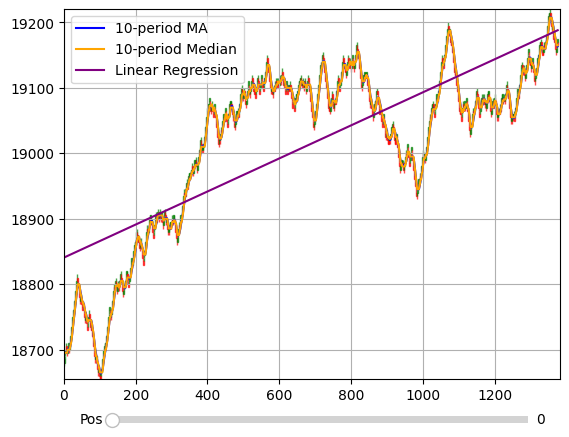

In [9]:
# Create the figure and axis
fig, axes = plt.subplots()

# Plot the Renko bars with correct sequencing
index = 0
for _, row in df.iterrows():
    if row['Color'] == 'G':  # Green for upward trend
        if row['EndPrice'] - row['StartPrice'] <= 5:
            renko = patches.Rectangle((index, row['StartPrice']), 1, row['EndPrice'] - row['StartPrice'], edgecolor='green', facecolor='green', alpha=0.7)
            index += 1  # Increment index after placing the Renko bar
        elif row['EndPrice'] - row['StartPrice'] > 5:
            renko = patches.Rectangle((index, row['StartPrice']+ 5), 1, 5, edgecolor='green', facecolor='green', alpha=0.7)
            index += 1  # Increment index after placing the Renko bar
    elif row['Color'] == 'R':  # Red for downward trend
        if row['StartPrice'] - row['EndPrice'] <= 5:
            renko = patches.Rectangle((index, row['StartPrice']), 1, row['EndPrice'] - row['StartPrice'], edgecolor='red', facecolor='red', alpha=0.7)
            index += 1  # Increment index after placing the Renko bar
        elif row['StartPrice'] - row['EndPrice'] > 5:
            renko = patches.Rectangle((index, row['EndPrice']), 1, 5, edgecolor='red', facecolor='red', alpha=0.7)
            index += 1  # Increment index after placing the Renko bar
    axes.add_patch(renko)

# Plot the moving average, median, and linear regression lines
axes.plot(df.index, df['MA'], color='blue', label=f'{window_size}-period MA')
axes.plot(df.index, df['Median'], color='orange', label=f'{window_size}-period Median')
axes.plot(df.index, df['LinearRegression'], color='purple', label='Linear Regression')

# Adjust the axes limits based on the data
axes.set_xlim([0, len(df) + 5])
axes.set_ylim([df['StartPrice'].min(), df['EndPrice'].max()])

# Add grid, legend, and show the plot
axes.grid(True)
axes.legend()

# Slider functionality
axcolor = 'lightgoldenrodyellow'
axpos = plt.axes([0.2, 0.01, 0.65, 0.03], facecolor=axcolor)

spos = Slider(axpos, 'Pos', 0, len(df) - 10, valinit=0, valstep=1)

def update(val):
    pos = spos.val
    axes.set_xlim([pos, pos + 10])
    fig.canvas.draw_idle()

spos.on_changed(update)
